In [19]:
!pip install -q torchtext==0.18.0
!pip install -q transformers  diffusers  pandas numpy
!pip install -Uq datasets huggingface_hub fsspec

In [20]:
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login
import os
import re
import collections
import datetime
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report
import datasets
import tqdm
import gradio as gr

In [21]:
#credintials
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#hyper_parameters
seed = 42
embedding_dim = 100
batch_size = 512
n_epochs = 50
model_name = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
classes = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

Using device: cpu


In [23]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(seed)

In [24]:
def load_and_prepare_data(seed=seed):
    train_data, test_data = datasets.load_dataset("dair-ai/emotion", split=["train", "test"])
    train_validation = train_data.train_test_split(test_size=0.25, seed=seed)
    train_data = train_validation['train']
    validation_data = train_validation['test']
    return train_data, validation_data, test_data

train_data, validation_data, test_data = load_and_prepare_data()

In [26]:
#tokenization
def tokenize_data(train_data, validation_data, test_data,autotokenizer):

  def _tokenize(batch):
    return autotokenizer(batch["text"], padding="max_length", truncation=True, max_length=embedding_dim)

  train_data_numericalized = train_data.map(_tokenize, batched=True, batch_size=len(train_data))
  validation_data_numericalized = validation_data.map(_tokenize, batched=True, batch_size=len(validation_data))
  test_data_numericalized = test_data.map(_tokenize, batched=True, batch_size=len(test_data))

  for ds in [train_data_numericalized, validation_data_numericalized, test_data_numericalized]:
    ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

  return train_data_numericalized, validation_data_numericalized, test_data_numericalized

autotokenizer = AutoTokenizer.from_pretrained(model_name)
train_data_numericalized, validation_data_numericalized, test_data_numericalized = tokenize_data(train_data, validation_data, test_data, autotokenizer)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
def create_data_loaders(train_data_numericalized, validation_data_numericalized, test_data_numericalized, batch_size):
    train_data_loader = DataLoader(train_data_numericalized, batch_size, shuffle=True)
    valid_data_loader = DataLoader(validation_data_numericalized, batch_size, shuffle=True)
    test_data_loader = DataLoader(test_data_numericalized, batch_size, shuffle=True)
    return train_data_loader, valid_data_loader, test_data_loader

train_data_loader, valid_data_loader, test_data_loader = create_data_loaders(
    train_data_numericalized, validation_data_numericalized, test_data_numericalized, batch_size
)

In [28]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index, h1, p):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.drop1 = nn.Dropout(p)
        self.fc1 = nn.Linear(embedding_dim, h1)
        self.r1 = nn.ReLU(inplace=True)
        self.b1 = nn.BatchNorm1d(h1)
        self.drop2 = nn.Dropout(p)
        self.fcf = nn.Linear(h1, output_dim)

    def forward(self, ids, attention_mask):
        embedded = self.embedding(ids)
        mask = attention_mask.unsqueeze(-1).float()
        masked_embedded = embedded * mask
        sum_embeddings = masked_embedded.sum(dim=1)
        lengths = mask.sum(dim=1)
        pooled = sum_embeddings / lengths.clamp(min=1e-9)
        x = self.drop1(pooled)
        x = self.fc1(x)
        x = self.r1(x)
        x = self.b1(x)
        x = self.drop2(x)
        prediction = self.fcf(x)
        return prediction

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in my_model.parameters() if p.requires_grad)

In [30]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [31]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses, epoch_accs = [], []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids, att)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [32]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses, epoch_accs = [], []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["input_ids"].to(device)
            att = batch["attention_mask"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids, att)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [33]:
def print_classification_summary(prediction, label, class_dict):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    true_labels = label.cpu().numpy()
    target_names = [class_dict[i] for i in range(len(class_dict))]
    report = classification_report(true_labels, predicted_classes, target_names=target_names, digits=3)
    print("\nClassification Summary:\n")
    print(report)

In [34]:
def predict_sentiment(text, model, tokenizer, device, embedding_dim, classes):
    obj = tokenizer(text, padding="max_length", truncation=True, max_length=embedding_dim)
    ids = obj['input_ids']
    atts = obj['attention_mask']
    tensor_id = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    tensor_att = torch.LongTensor(atts).unsqueeze(dim=0).to(device)
    prediction = model(tensor_id, tensor_att).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return classes[predicted_class], predicted_probability

In [35]:
def plot_metrics(metrics, n_epochs):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].plot(metrics["train_losses"], label="train loss")
    ax[0].plot(metrics["valid_losses"], label="valid loss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].set_xticks(range(n_epochs))
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(metrics["train_accs"], label="train accuracy")
    ax[1].plot(metrics["valid_accs"], label="valid accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].set_xticks(range(n_epochs))
    ax[1].legend()
    ax[1].grid()
    plt.show()

In [36]:
def training_loops(metrics,best_valid_loss, my_model, n_epochs = n_epochs, saving = False):
  for epoch in range(n_epochs):
      train_loss, train_acc = train(
          train_data_loader, my_model, criterion, optimizer, device
      )
      valid_loss, valid_acc = evaluate(valid_data_loader, my_model, criterion, device)
      metrics["train_losses"].append(train_loss)
      metrics["train_accs"].append(train_acc)
      metrics["valid_losses"].append(valid_loss)
      metrics["valid_accs"].append(valid_acc)
      if valid_loss < best_valid_loss and saving == True:
          best_valid_loss = valid_loss
          id = datetime.datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
          torch.save(my_model.state_dict(), "nbow_"+id+".pt")
      print(f"epoch: {epoch}")
      print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
      print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
  return metrics


In [37]:
#model instantiation
best_valid_loss = float("inf")
metrics = collections.defaultdict(list)
my_model = NBoW(
    vocab_size=autotokenizer.vocab_size,
    embedding_dim=embedding_dim,
    output_dim=len(train_data.unique("label")),
    pad_index=autotokenizer.pad_token_type_id,
    h1=64,
    p=0.3
).to(device)
print(my_model)
print(f"The model has {count_parameters(my_model):,} trainable parameters")
optimizer = optim.Adam(my_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Flattening the indices:   0%|          | 0/12000 [00:00<?, ? examples/s]

NBoW(
  (embedding): Embedding(30522, 100, padding_idx=0)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (r1): ReLU(inplace=True)
  (b1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fcf): Linear(in_features=64, out_features=6, bias=True)
)
The model has 3,059,182 trainable parameters


In [38]:
#calling training loop
metrics = training_loops(metrics,best_valid_loss, my_model, n_epochs, True)

evaluating...: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


epoch: 0
train_loss: 1.847, train_acc: 0.216
valid_loss: 1.711, valid_acc: 0.351


evaluating...: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]


epoch: 1
train_loss: 1.723, train_acc: 0.285
valid_loss: 1.660, valid_acc: 0.370


evaluating...: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


epoch: 2
train_loss: 1.663, train_acc: 0.337
valid_loss: 1.610, valid_acc: 0.387


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  6.54it/s]


epoch: 3
train_loss: 1.619, train_acc: 0.368
valid_loss: 1.567, valid_acc: 0.407


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 10.87it/s]


epoch: 4
train_loss: 1.569, train_acc: 0.392
valid_loss: 1.529, valid_acc: 0.416


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]


epoch: 5
train_loss: 1.533, train_acc: 0.406
valid_loss: 1.493, valid_acc: 0.428


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


epoch: 6
train_loss: 1.489, train_acc: 0.430
valid_loss: 1.458, valid_acc: 0.442


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


epoch: 7
train_loss: 1.454, train_acc: 0.446
valid_loss: 1.426, valid_acc: 0.456


evaluating...: 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


epoch: 8
train_loss: 1.421, train_acc: 0.454
valid_loss: 1.391, valid_acc: 0.472


evaluating...: 100%|██████████| 8/8 [00:00<00:00,  9.17it/s]


epoch: 9
train_loss: 1.385, train_acc: 0.479
valid_loss: 1.360, valid_acc: 0.488


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 10.95it/s]


epoch: 10
train_loss: 1.340, train_acc: 0.496
valid_loss: 1.328, valid_acc: 0.505


evaluating...: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


epoch: 11
train_loss: 1.305, train_acc: 0.508
valid_loss: 1.293, valid_acc: 0.519


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]


epoch: 12
train_loss: 1.268, train_acc: 0.528
valid_loss: 1.261, valid_acc: 0.533


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


epoch: 13
train_loss: 1.229, train_acc: 0.542
valid_loss: 1.228, valid_acc: 0.541


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 19.80it/s]


epoch: 14
train_loss: 1.198, train_acc: 0.560
valid_loss: 1.191, valid_acc: 0.554


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 13.29it/s]


epoch: 15
train_loss: 1.153, train_acc: 0.574
valid_loss: 1.156, valid_acc: 0.569


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 14.74it/s]


epoch: 16
train_loss: 1.115, train_acc: 0.592
valid_loss: 1.122, valid_acc: 0.578


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]


epoch: 17
train_loss: 1.076, train_acc: 0.607
valid_loss: 1.091, valid_acc: 0.590


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s]


epoch: 18
train_loss: 1.030, train_acc: 0.625
valid_loss: 1.062, valid_acc: 0.606


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.23it/s]


epoch: 19
train_loss: 0.998, train_acc: 0.636
valid_loss: 1.024, valid_acc: 0.621


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 19.30it/s]


epoch: 20
train_loss: 0.947, train_acc: 0.657
valid_loss: 0.991, valid_acc: 0.633


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 13.08it/s]


epoch: 21
train_loss: 0.911, train_acc: 0.674
valid_loss: 0.962, valid_acc: 0.641


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.96it/s]


epoch: 22
train_loss: 0.885, train_acc: 0.681
valid_loss: 0.935, valid_acc: 0.651


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.98it/s]


epoch: 23
train_loss: 0.864, train_acc: 0.688
valid_loss: 0.912, valid_acc: 0.661


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s]


epoch: 24
train_loss: 0.814, train_acc: 0.706
valid_loss: 0.886, valid_acc: 0.670


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.88it/s]


epoch: 25
train_loss: 0.784, train_acc: 0.719
valid_loss: 0.864, valid_acc: 0.680


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s]


epoch: 26
train_loss: 0.748, train_acc: 0.733
valid_loss: 0.840, valid_acc: 0.691


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 13.41it/s]


epoch: 27
train_loss: 0.723, train_acc: 0.743
valid_loss: 0.820, valid_acc: 0.701


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 17.03it/s]


epoch: 28
train_loss: 0.684, train_acc: 0.756
valid_loss: 0.798, valid_acc: 0.705


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s]


epoch: 29
train_loss: 0.667, train_acc: 0.759
valid_loss: 0.780, valid_acc: 0.714


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.44it/s]


epoch: 30
train_loss: 0.627, train_acc: 0.779
valid_loss: 0.764, valid_acc: 0.721


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s]


epoch: 31
train_loss: 0.610, train_acc: 0.783
valid_loss: 0.748, valid_acc: 0.728


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 12.67it/s]


epoch: 32
train_loss: 0.585, train_acc: 0.792
valid_loss: 0.733, valid_acc: 0.734


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.63it/s]


epoch: 33
train_loss: 0.563, train_acc: 0.801
valid_loss: 0.722, valid_acc: 0.738


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 13.65it/s]


epoch: 34
train_loss: 0.543, train_acc: 0.809
valid_loss: 0.709, valid_acc: 0.744


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s]


epoch: 35
train_loss: 0.526, train_acc: 0.815
valid_loss: 0.699, valid_acc: 0.747


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


epoch: 36
train_loss: 0.495, train_acc: 0.828
valid_loss: 0.687, valid_acc: 0.753


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 15.05it/s]


epoch: 37
train_loss: 0.488, train_acc: 0.831
valid_loss: 0.674, valid_acc: 0.756


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


epoch: 38
train_loss: 0.479, train_acc: 0.830
valid_loss: 0.667, valid_acc: 0.762


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s]


epoch: 39
train_loss: 0.461, train_acc: 0.840
valid_loss: 0.659, valid_acc: 0.761


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 17.48it/s]


epoch: 40
train_loss: 0.439, train_acc: 0.845
valid_loss: 0.652, valid_acc: 0.768


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s]


epoch: 41
train_loss: 0.440, train_acc: 0.847
valid_loss: 0.644, valid_acc: 0.769


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 16.71it/s]


epoch: 42
train_loss: 0.410, train_acc: 0.857
valid_loss: 0.637, valid_acc: 0.774


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


epoch: 43
train_loss: 0.398, train_acc: 0.861
valid_loss: 0.629, valid_acc: 0.777


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 17.14it/s]


epoch: 44
train_loss: 0.382, train_acc: 0.866
valid_loss: 0.623, valid_acc: 0.779


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 17.74it/s]


epoch: 45
train_loss: 0.378, train_acc: 0.865
valid_loss: 0.620, valid_acc: 0.780


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.95it/s]


epoch: 46
train_loss: 0.372, train_acc: 0.871
valid_loss: 0.619, valid_acc: 0.783


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


epoch: 47
train_loss: 0.349, train_acc: 0.883
valid_loss: 0.613, valid_acc: 0.786


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


epoch: 48
train_loss: 0.340, train_acc: 0.883
valid_loss: 0.614, valid_acc: 0.783


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 13.88it/s]

epoch: 49
train_loss: 0.331, train_acc: 0.885
valid_loss: 0.606, valid_acc: 0.786


In [39]:
#addtional_training
Addition_epochs=0
metrics = training_loops(metrics,best_valid_loss, my_model, Addition_epochs, True)
n_epochs += Addition_epochs

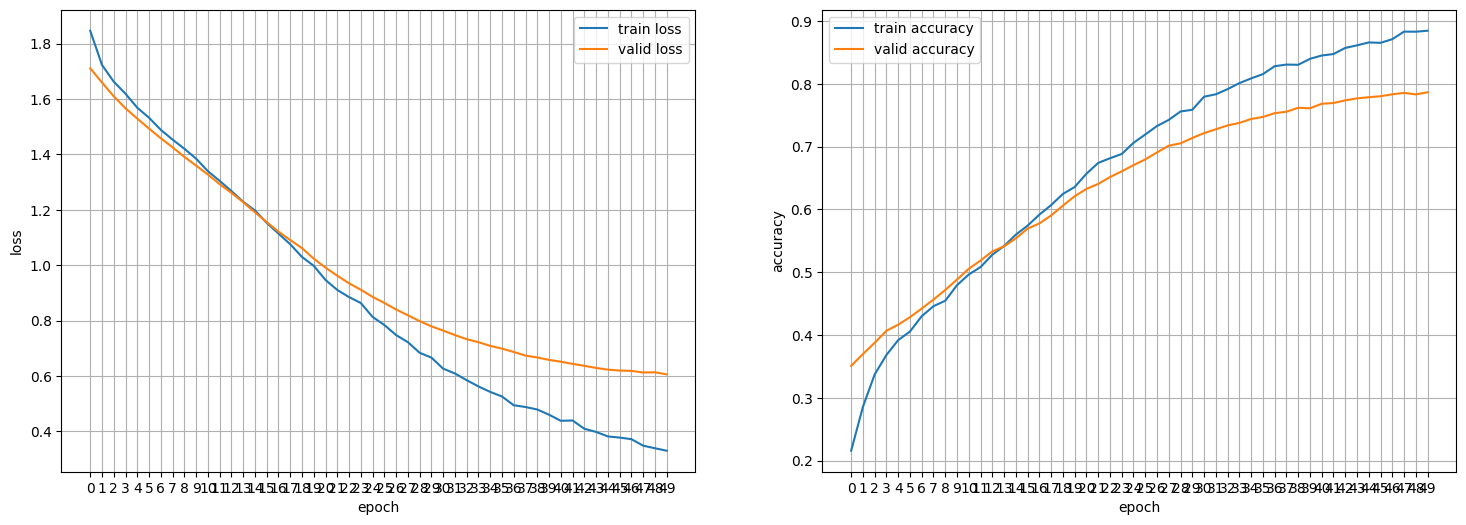

In [40]:
#plot train and validation loss and accuracy
plot_metrics(metrics, n_epochs)

In [41]:
# Test evaluation
test_loss, test_acc = evaluate(test_data_loader, my_model, criterion, device)
print("\ntest_loss", test_loss)
print("test_accuracy", test_acc)


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 19.73it/s]


test_loss 0.5582883059978485
test_accuracy 0.8067248165607452


In [42]:
# Classification report
with torch.no_grad():
    all_preds, all_labels = [], []
    for batch in tqdm.tqdm(test_data_loader, desc="evaluating..."):
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        label = batch["label"].to(device)
        prediction = my_model(ids, att)
        all_preds.append(prediction)
        all_labels.append(label)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    print_classification_summary(all_preds, all_labels, classes)

evaluating...: 100%|██████████| 4/4 [00:00<00:00, 18.86it/s]


Classification Summary:

              precision    recall  f1-score   support

     sadness      0.831     0.871     0.850       581
         joy      0.819     0.899     0.857       695
        love      0.724     0.560     0.631       159
       anger      0.792     0.760     0.776       275
        fear      0.813     0.661     0.729       224
    surprise      0.627     0.561     0.592        66

    accuracy                          0.807      2000
   macro avg      0.768     0.719     0.739      2000
weighted avg      0.804     0.807     0.803      2000



In [43]:
# Example predictions
example_texts = [
    "iam happy to meet you",
    "i love you",
    "iam very upset iam sick",
    "i cant stand delaying my PhD defense any more",
    "i can punhs them in the face right now",
    "the hardest part about growing up is saying goodby to childhood dreams",
    "how did you do that to me?",
    "how dare you stand where he stod?"
]
for text in example_texts:
    sentiment, prob = predict_sentiment(text, my_model, autotokenizer, device, embedding_dim, classes)
    print(f"Text: {text}\nPredicted: {sentiment} ({prob:.3f})\n")

Text: iam happy to meet you
Predicted: joy (0.639)

Text: i love you
Predicted: love (0.832)

Text: iam very upset iam sick
Predicted: sadness (0.588)

Text: i cant stand delaying my PhD defense any more
Predicted: joy (0.462)

Text: i can punhs them in the face right now
Predicted: anger (0.875)

Text: the hardest part about growing up is saying goodby to childhood dreams
Predicted: surprise (0.351)

Text: how did you do that to me?
Predicted: joy (0.353)

Text: how dare you stand where he stod?
Predicted: fear (0.680)



In [44]:
#save the model using pckl file
import pickle
id = datetime.datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
with open('/content/drive/MyDrive/Sentiment_analysis/model_sentiment_'+id+'.pkl', 'wb') as f:
    pickle.dump(my_model, f)

In [45]:
def gradio_predict(text):
      sentiment, prob = predict_sentiment(
          text, my_model, autotokenizer, device, embedding_dim, classes
      )
      return f"{sentiment} ({prob:.2f} confidence)"

# Launch Gradio interface
demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=3, placeholder="Enter a sentence..."),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Sentiment Analysis with NBoW",
    description="Enter a sentence to analyze its sentiment using a custom neural bag-of-words model.",
    examples=[ example_texts[i] for i in range(len(example_texts)) ]
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9342d7e2717d97c2d2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
